In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

In [45]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})

# Ajustes en los archivos antes de procesar

In [46]:
vistas.rename(columns={"idAviso":"idaviso"}, inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-16 02:12:22.644726')

In [47]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones[['fechapostulacion']] = postulaciones[['fechapostulacion']].apply(pd.to_datetime)
now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)

Timestamp('2018-04-16 02:12:52.127086')

In [48]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

# Empieza el analisis

In [49]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

In [50]:
valores_educacion.nombre = valores_educacion.nombre.astype('category', categories=post_educacion.nombre.cat.categories)
valores_educacion.memory_usage(deep=True)

Index                80
estado             1379
nombre              850
valor_educacion     168
dtype: int64

In [51]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

In [52]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [53]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])

post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [54]:
postulantes = pd.merge(post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
postulantes.head()

,idpostulante,nombre,estado,valor_educacion,fechanacimiento,sexo,edad
0,NdJl,Posgrado,En Curso,15,1969-05-09,MASC,48.0
1,axaPJ,Posgrado,En Curso,15,1970-01-06,MASC,48.0
2,Z48mz,Posgrado,En Curso,15,1967-05-16,MASC,50.0
3,a4zEZ,Posgrado,En Curso,15,1976-04-10,MASC,42.0
4,6AWqO,Posgrado,En Curso,15,1970-05-21,MASC,47.0


# Relacion entre cantidad de postulaciones y vistas por aviso

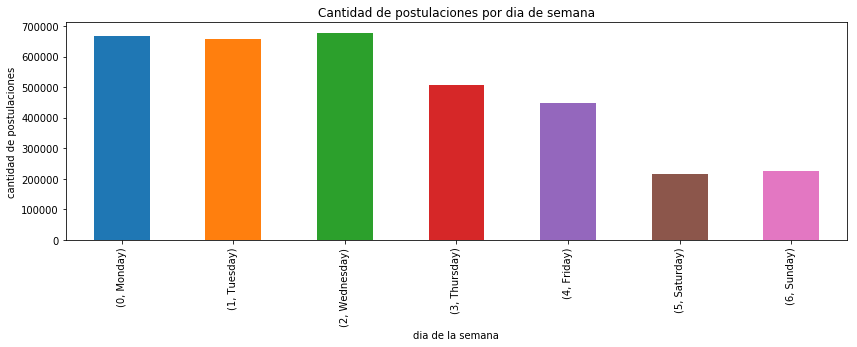

In [55]:
#cantidad de postulaciones por dia de semana
post_weekday = postulaciones
post_weekday['weekday'] = post_weekday['fechapostulacion'].dt.weekday_name
post_weekday['dayofweek'] = post_weekday['fechapostulacion'].dt.dayofweek
post_weekday_groupby = post_weekday.groupby(['dayofweek','weekday']).count()['fechapostulacion']
post_weekday_groupby.plot(title = "Cantidad de postulaciones por dia de semana",kind='bar',figsize=(14,4))
plt.xlabel('dia de la semana')
plt.ylabel('cantidad de postulaciones')
plt.show()

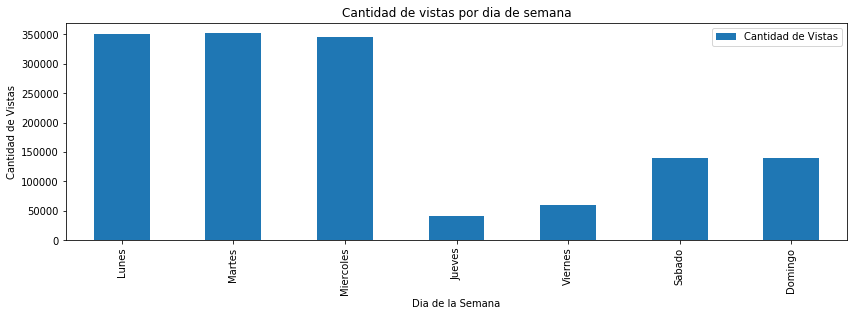

In [56]:
# Cantidad de Vistas por dia de semana

# Se llego a la conclusion de que la cantidad de vistas totales son los registros del 
# archivo vistas + archivo postulaciones

# Tomo la fecha minima de las vistas, para filtrar las postulaciones y asegurarme que tengo los mismos rangos de tiempo
# (ultimos 7 dias) para comparar.
min_vista_fecha = vistas['fechavista'].sort_values().loc[0]

ax = plt.gca()

vistas_weekday = postulaciones[postulaciones["fechapostulacion"] >= min_vista_fecha]
vistas_weekday.rename(columns={"fechapostulacion":"fechavista"}, inplace=True)
vistas_weekday = pd.concat([vistas, vistas_weekday])
vistas_weekday['weekday'] = vistas_weekday['fechavista'].dt.weekday_name
vistas_weekday['dayofweek'] = vistas_weekday['fechavista'].dt.dayofweek
vistas_weekday_groupby = vistas_weekday.groupby(['dayofweek','weekday']).count()['fechavista'].reset_index()
vistas_weekday_groupby.set_index('weekday', inplace=True)
vistas_weekday_groupby.drop('dayofweek', inplace=True, axis=1)
vistas_weekday_groupby.index.name = None
vistas_weekday_groupby.rename({'fechavista': 'Cantidad de Vistas'}, inplace=True, axis=1)

vistas_weekday_groupby.rename({
    'Monday' : 'Lunes',
    'Tuesday' : 'Martes',
    'Wednesday' : 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday' : 'Viernes',
    'Saturday' : 'Sabado',
    'Sunday' : 'Domingo'
}, axis=0, inplace=True)


vistas_weekday_groupby.plot(ax = ax, title = "Cantidad de vistas por dia de semana",kind='bar',figsize=(14,4))
# vistas_weekday_groupby.plot(ax = ax, title = "Cantidad de vistas por dia de semana",kind='line',figsize=(14,4), secondary_y=True)

plt.xlabel('Dia de la Semana')
plt.ylabel('Cantidad de Vistas');

In [57]:
#cantidad de postulaciones
# Tomo la fecha minima de las vistas, para filtrar las postulaciones y asegurarme que tengo los mismos rangos de tiempo
# (ultimos 7 dias) para comparar.
min_vista_fecha = vistas['fechavista'].sort_values().loc[0]
avisos_cant_post = postulaciones[postulaciones["fechapostulacion"] >= min_vista_fecha]
avisos_cant_post = avisos_cant_post.loc[:,['idaviso']]
avisos_cant_post = avisos_cant_post.groupby(['idaviso']).size()
avisos_cant_post = avisos_cant_post.sort_values(ascending=False)
avisos_cant_post = pd.DataFrame(avisos_cant_post).reset_index()
avisos_cant_post[["idaviso", "cant_post"]] = avisos_cant_post[["idaviso", 0]]
avisos_cant_post = avisos_cant_post[["idaviso", "cant_post"]]  
avisos_cant_post.head()

,idaviso,cant_post
0,1112359836,4059
1,1112366909,2885
2,1112369306,2450
3,1112366913,2343
4,1112334791,2305


In [58]:
avisos_cant_post.describe()

,idaviso,cant_post
count,5.708000e+03,5708.000000
mean,1.111371e+09,81.860371
std,2.193517e+07,183.039775
min,1.254376e+07,1.000000
25%,1.112299e+09,10.000000
50%,1.112323e+09,27.000000
75%,1.112350e+09,74.000000
max,1.112370e+09,4059.000000


In [59]:
#cantidad de vistas
#relacion post vs vistas
# Tomo la fecha minima de las vistas, para filtrar las postulaciones y asegurarme que tengo los mismos rangos de tiempo
# (ultimos 7 dias) para comparar.
min_vista_fecha = vistas['fechavista'].sort_values().loc[0]
avisos_cant_vistas = postulaciones[postulaciones["fechapostulacion"] >= min_vista_fecha]
avisos_cant_vistas.rename(columns={"fechapostulacion":"fechavista"}, inplace=True)
avisos_cant_vistas = pd.concat([vistas, avisos_cant_vistas])
avisos_cant_vistas = avisos_cant_vistas.loc[:,['idaviso']]
avisos_cant_vistas = avisos_cant_vistas.groupby(['idaviso']).size()
avisos_cant_vistas = avisos_cant_vistas.sort_values(ascending=False)
avisos_cant_vistas = pd.DataFrame(avisos_cant_vistas).reset_index()
avisos_cant_vistas[["idaviso", "cant_vistas"]] = avisos_cant_vistas[["idaviso", 0]]
avisos_cant_vistas = avisos_cant_vistas[["idaviso", "cant_vistas"]]  
avisos_cant_vistas.head()

,idaviso,cant_vistas
0,1112359836,8179
1,1112366909,6554
2,1112369306,5686
3,1112352317,5639
4,1112363488,5413


In [60]:
#relacion post vs vistas
post_vs_vistas =  pd.merge(avisos_cant_post, avisos_cant_vistas, on="idaviso", how='inner')
post_vs_vistas = post_vs_vistas[["idaviso", "cant_post", "cant_vistas"]] 
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas
0,1112359836,4059,8179
1,1112366909,2885,6554
2,1112369306,2450,5686
3,1112366913,2343,4593
4,1112334791,2305,5122


In [61]:
#calculo la probabilidad de que alguien se postule
# post_vs_vistas.dropna()
post_vs_vistas['prob_post'] = post_vs_vistas.cant_post / post_vs_vistas.cant_vistas
post_vs_vistas = post_vs_vistas.sort_values(by='prob_post', ascending=True)
post_vs_vistas.head()

,idaviso,cant_post,cant_vistas,prob_post
5461,1112359511,2,133,0.015038
5672,1112289757,1,62,0.016129
5292,1112361790,2,112,0.017857
5706,1112288001,1,49,0.020408
5666,1112289245,1,41,0.024390


In [62]:
post_vs_vistas.describe()

,idaviso,cant_post,cant_vistas,prob_post
count,5.708000e+03,5708.000000,5708.000000,5708.000000
mean,1.111371e+09,81.860371,249.240189,0.332769
std,2.193517e+07,183.039775,481.651671,0.215301
min,1.254376e+07,1.000000,1.000000,0.015038
25%,1.112299e+09,10.000000,36.000000,0.221279
50%,1.112323e+09,27.000000,96.000000,0.280561
75%,1.112350e+09,74.000000,246.000000,0.354580
max,1.112370e+09,4059.000000,8179.000000,1.000000


In [63]:
#Para que los datos sean consistentes, filtro la cantidad de vistas menor al 25%, de cantidad 36 ya que el min es 1 y max 8179  
post_vs_vistas = post_vs_vistas[post_vs_vistas['cant_vistas'] >= 36]
post_vs_vistas.describe()

,idaviso,cant_post,cant_vistas,prob_post
count,4.305000e+03,4305.000000,4305.000000,4305.000000
mean,1.111257e+09,106.608595,324.859698,0.310431
std,2.485967e+07,204.750543,533.207089,0.165957
min,1.254376e+07,1.000000,36.000000,0.015038
25%,1.112303e+09,20.000000,74.000000,0.226829
50%,1.112335e+09,42.000000,147.000000,0.280702
75%,1.112354e+09,103.000000,334.000000,0.344423
max,1.112370e+09,4059.000000,8179.000000,1.000000


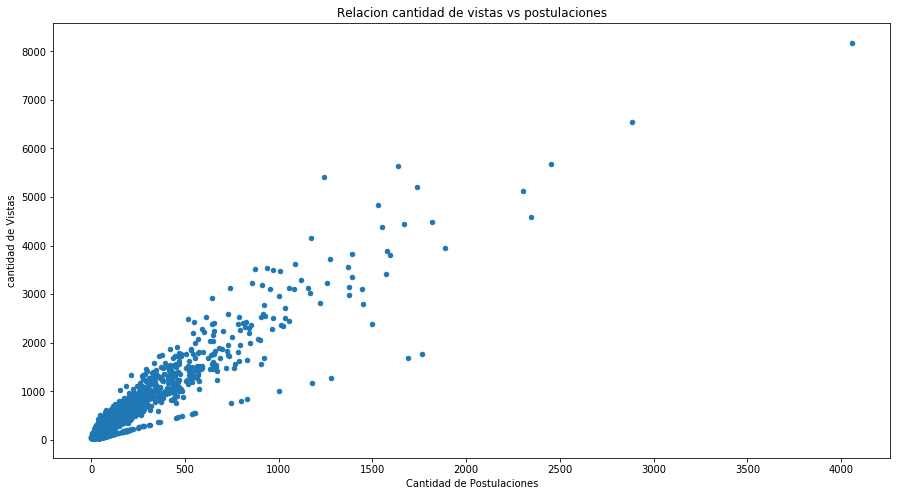

In [64]:
post_vs_vistas.plot.scatter('cant_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas vs postulaciones",figsize=(15,8));
plt.xlabel('Cantidad de Postulaciones')
plt.ylabel('cantidad de Vistas')
plt.show()

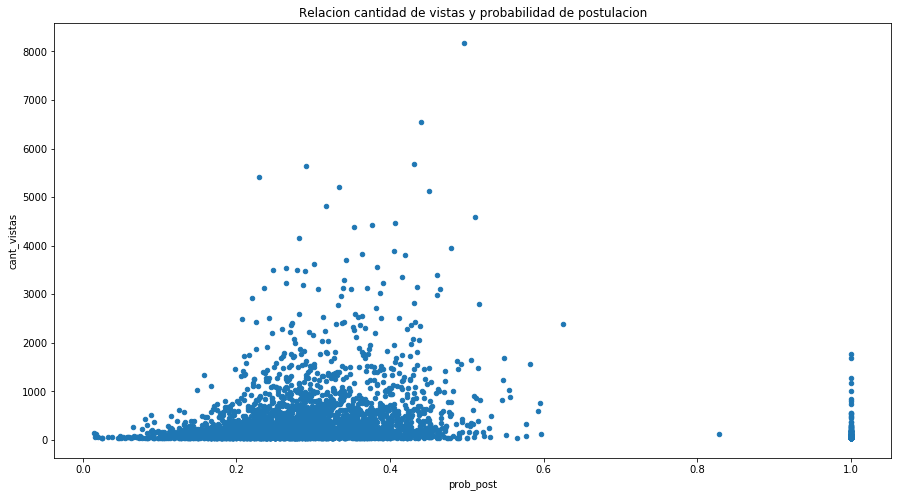

In [65]:
post_vs_vistas.plot.scatter('prob_post','cant_vistas',alpha=1,title = "Relacion cantidad de vistas y probabilidad de postulacion",figsize=(15,8));

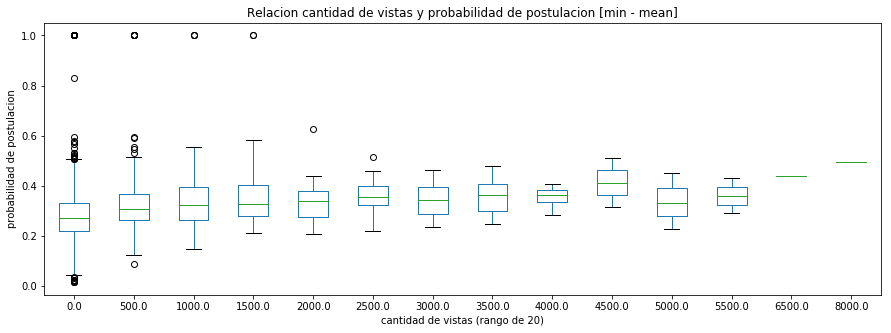

In [66]:
#relacion de cantidad de vistas con la probabilidad de postulacion
#separo en 3 partes, del min al mean y del mean al std y del std al max, donde el promedio de visitas es 325  y desviacion standard 534 aprox.
# post_vs_vistas_box_min = post_vs_vistas[post_vs_vistas['cant_vistas'] <= 325]
post_vs_vistas_box_min = post_vs_vistas.copy()
post_vs_vistas_box_min['cant_vistas_rg'] = np.floor( post_vs_vistas_box_min['cant_vistas'].apply(lambda x: x /500) )
post_vs_vistas_box_min['cant_vistas_rg'] = post_vs_vistas_box_min['cant_vistas_rg'].apply(lambda x: x*500)
post_vs_vistas_box_min = post_vs_vistas_box_min.loc[:,['cant_vistas_rg','prob_post']]
post_vs_vistas_box_min['subindex'] = post_vs_vistas_box_min.groupby('cant_vistas_rg').cumcount() + 1
post_vs_vistas_box_min = pd.pivot_table(post_vs_vistas_box_min,index='subindex',columns='cant_vistas_rg',values='prob_post')
post_vs_vistas_box_min.plot.box(title = "Relacion cantidad de vistas y probabilidad de postulacion [min - mean]", figsize=(15,5));
plt.xlabel('cantidad de vistas (rango de 20)')
plt.ylabel('probabilidad de postulacion')
plt.show()

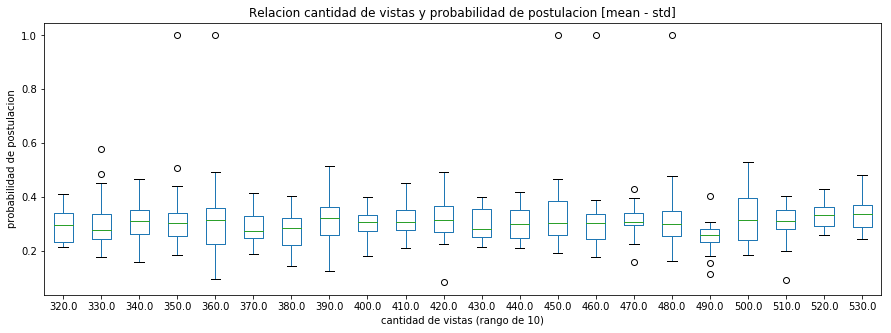

In [67]:
post_vs_vistas_box_75 = post_vs_vistas[post_vs_vistas['cant_vistas'] > 325]
post_vs_vistas_box_75 = post_vs_vistas_box_75[post_vs_vistas_box_75['cant_vistas'] <= 534]
post_vs_vistas_box_75['cant_vistas_rg'] = np.floor( post_vs_vistas_box_75['cant_vistas'].apply(lambda x: x /10) )
post_vs_vistas_box_75['cant_vistas_rg'] = post_vs_vistas_box_75['cant_vistas_rg'].apply(lambda x: x*10)
post_vs_vistas_box_75 = post_vs_vistas_box_75.loc[:,['cant_vistas_rg','prob_post']]
post_vs_vistas_box_75['subindex'] = post_vs_vistas_box_75.groupby('cant_vistas_rg').cumcount() + 1
post_vs_vistas_box_75 = pd.pivot_table(post_vs_vistas_box_75,index='subindex',columns='cant_vistas_rg',values='prob_post')
post_vs_vistas_box_75.plot.box(title = "Relacion cantidad de vistas y probabilidad de postulacion [mean - std]", figsize=(15,5));
plt.xlabel('cantidad de vistas (rango de 10)')
plt.ylabel('probabilidad de postulacion')
plt.show()

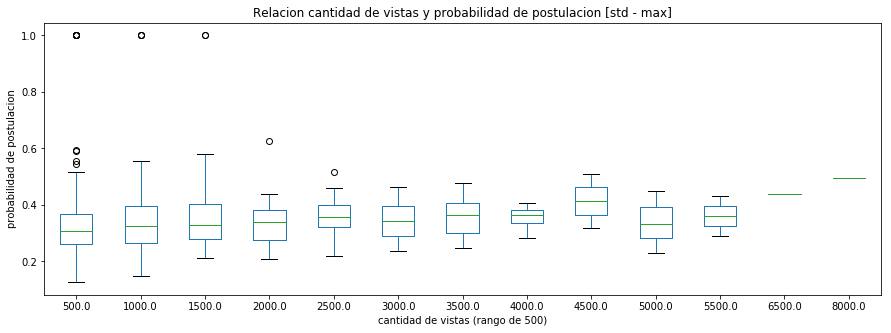

In [68]:
post_vs_vistas_box_max = post_vs_vistas[post_vs_vistas['cant_vistas'] > 534]
post_vs_vistas_box_max['cant_vistas_rg'] = np.floor( post_vs_vistas_box_max['cant_vistas'].apply(lambda x: x /500) )
post_vs_vistas_box_max['cant_vistas_rg'] = post_vs_vistas_box_max['cant_vistas_rg'].apply(lambda x: x*500)
post_vs_vistas_box_max = post_vs_vistas_box_max.loc[:,['cant_vistas_rg','prob_post']]
post_vs_vistas_box_max['subindex'] = post_vs_vistas_box_max.groupby('cant_vistas_rg').cumcount() + 1
post_vs_vistas_box_max = pd.pivot_table(post_vs_vistas_box_max,index='subindex',columns='cant_vistas_rg',values='prob_post')
post_vs_vistas_box_max.plot.box(title = "Relacion cantidad de vistas y probabilidad de postulacion [std - max]", figsize=(15,5));
plt.xlabel('cantidad de vistas (rango de 500)')
plt.ylabel('probabilidad de postulacion')
plt.show()

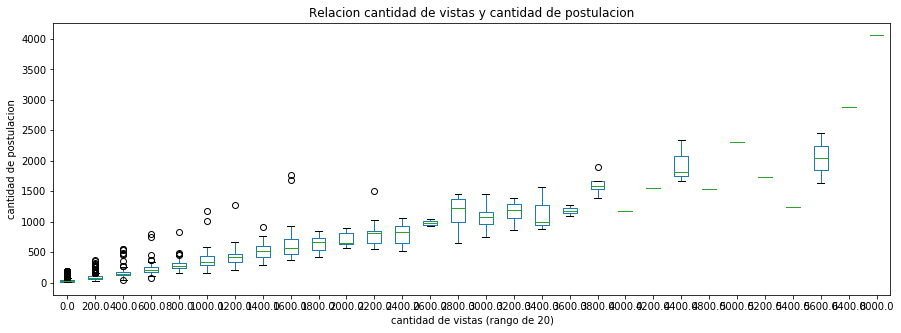

In [71]:
post_vs_vistas_box_min = post_vs_vistas.copy()
post_vs_vistas_box_min['cant_vistas_rg'] = np.floor( post_vs_vistas_box_min['cant_vistas'].apply(lambda x: x /200) )
post_vs_vistas_box_min['cant_vistas_rg'] = post_vs_vistas_box_min['cant_vistas_rg'].apply(lambda x: x*200)
post_vs_vistas_box_min = post_vs_vistas_box_min.loc[:,['cant_vistas_rg','cant_post']]
post_vs_vistas_box_min['subindex'] = post_vs_vistas_box_min.groupby('cant_vistas_rg').cumcount() + 1
post_vs_vistas_box_min = pd.pivot_table(post_vs_vistas_box_min,index='subindex',columns='cant_vistas_rg',values='cant_post')
post_vs_vistas_box_min.plot.box(title = "Relacion cantidad de vistas y cantidad de postulacion", figsize=(15,5));
plt.xlabel('cantidad de vistas (rango de 20)')
plt.ylabel('cantidad de postulacion')
plt.show()

In [69]:
#cantidad de postulaciones por dia y hora de semana
post_weekday_hour = post_weekday
post_weekday_hour['hour'] = post_weekday_hour['fechavista'].dt.hour
post_weekday_hour = post_weekday_hour.loc[:,['idaviso','weekday','hour']]

#separo por dia
post_Monday = post_weekday_hour[post_weekday_hour.weekday == 'Monday']
post_Tuesday = post_weekday_hour[post_weekday_hour.weekday == 'Tuesday']
post_Wednesday = post_weekday_hour[post_weekday_hour.weekday == 'Wednesday']
post_Thursday = post_weekday_hour[post_weekday_hour.weekday == 'Thursday']
post_Friday = post_weekday_hour[post_weekday_hour.weekday == 'Friday']
post_Saturday = post_weekday_hour[post_weekday_hour.weekday == 'Saturday']
post_Sunday = post_weekday_hour[post_weekday_hour.weekday == 'Sunday']

#agrupo por hora por cada dia con la cantidad de postulaciones
post_Monday = post_Monday.groupby('hour', as_index=False)['idaviso'].count()
post_Monday.columns = ['hour', 'Lunes']
post_Tuesday = post_Tuesday.groupby('hour', as_index=False)['idaviso'].count()
post_Tuesday.columns = ['hour', 'Martes']
post_Wednesday = post_Wednesday.groupby('hour', as_index=False)['idaviso'].count()
post_Wednesday.columns = ['hour', 'Miercoles']
post_Thursday = post_Thursday.groupby('hour', as_index=False)['idaviso'].count()
post_Thursday.columns = ['hour', 'Jurves']
post_Friday = post_Friday.groupby('hour', as_index=False)['idaviso'].count()
post_Friday.columns = ['hour', 'Viernes']
post_Saturday = post_Saturday.groupby('hour', as_index=False)['idaviso'].count()
post_Saturday.columns = ['hour', 'Sabado']
post_Sunday = post_Sunday.groupby('hour', as_index=False)['idaviso'].count()
post_Sunday.columns = ['hour', 'Domingo']

#junto los dias
post_weekday_hour = pd.merge(post_Monday, post_Tuesday, on='hour')
post_weekday_hour = pd.merge(post_weekday_hour, post_Wednesday, on='hour')
post_weekday_hour = pd.merge(post_weekday_hour, post_Thursday, on='hour')
post_weekday_hour = pd.merge(post_weekday_hour, post_Friday, on='hour')
post_weekday_hour = pd.merge(post_weekday_hour, post_Saturday, on='hour')
post_weekday_hour = pd.merge(post_weekday_hour, post_Sunday, on='hour')
post_weekday_hour.head()

post_weekday_hour.plot(x='hour', title="Cantidad de postulaciones por dia y hora de semana",
            color=['#3336FF','#33FF49','#FF3333','#F3FF33','#55F1F1','#000000','#93881A'])
plt.xlabel('hora del dia de la semana')
plt.ylabel('cantidad de postulaciones')
plt.show()

KeyError: 'fechavista'

In [28]:
post_vs_vistas_detalle = post_vs_vistas.merge(avisos_detalles, on="idaviso")
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112359511,2,133,0.015038,Docentes,<p>Nos encontramos en la bùsqueda de docentes ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Educación,Neo-Biz Consultores
1,1112360257,17,219,0.077626,Analista de Compensaciones (Eventual),<p>Tiene por objetivo liquidar sueldos y carga...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,RRHH,ARENA MAIPU
2,1112363426,16,181,0.088398,Ingeniero Civil - Proyectista (Bíos para Impor...,"<p align=""center""><strong>Ingeniero Civil - Pr...",Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Arquitectura y Diseño,Bios - Recursos Humanos
3,1112362228,18,199,0.090452,PRODUCTOR ASESOR DE SEGUROS,Nos encontramos en la búsqueda de productores ...,Gran Buenos Aires,NaN,NaN,Full-time,Otro,Seguros,GABRIELA TOTARO
4,1112360818,15,164,0.091463,enfermera para institucion de discapacitados,"<p><span style=""text-decoration: underline;"">A...",Capital Federal,NaN,Bahía Blanca,Full-time,Junior,Salud,incudi


In [29]:
#filtro campos importantes
post_vs_vistas_detalle = post_vs_vistas_detalle.loc[:, ['idaviso','cant_post','cant_vistas','prob_post','tipo_de_trabajo','nivel_laboral','nombre_area','denominacion_empresa']]
post_vs_vistas_detalle.head()

,idaviso,cant_post,cant_vistas,prob_post,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,1112359511,2,133,0.015038,Full-time,Senior / Semi-Senior,Educación,Neo-Biz Consultores
1,1112360257,17,219,0.077626,Full-time,Senior / Semi-Senior,RRHH,ARENA MAIPU
2,1112363426,16,181,0.088398,Full-time,Senior / Semi-Senior,Arquitectura y Diseño,Bios - Recursos Humanos
3,1112362228,18,199,0.090452,Full-time,Otro,Seguros,GABRIELA TOTARO
4,1112360818,15,164,0.091463,Full-time,Junior,Salud,incudi
